### В данном ноутбуке мы будем подходить к задаче определения качества вина как в задаче регрессии.

## Качество вина 

Задача заключается в предсказании качества вина на основе его химических характеристик. 

Числовой датасет. Включает себя информацию о химических характеристик вина и его оценку по шкале от 0 до 10. Состоит из 4898 наблюдений. 

[1. Описание датасета](https://archive.ics.uci.edu/ml/datasets/wine+quality) 

[2. Расположение .csv файла](http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/) 

#### Входные переменные (на основе физико-химических тестов):

1 - **[fixed acidity]** фиксированная кислотность  

2 - **[volatile acidity]** летучая кислотность  

3 - **[citric acid]** лимонная кислота  

4 - **[residual sugar]** остаточный сахар  

5 - **[chlorides]** хлориды  

6 - **[free sulfur dioxide]**	свободный диоксид серы  

7 -  **[total sulfur dioxide]** общий диоксид серы  

8 - **[density]** плотность  

9 - **[рН]**  

10 - **[sulphates]** сульфаты  

11 - **[alcohol]** алкоголь  

-----------------------------------------------
#### Выходная переменная (на основе сенсорных данных):  

12 - **[quality]** качество (оценка от 0 до 10)

In [1]:
# download dataset
!wget 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

--2021-07-28 12:13:41--  http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264426 (258K) [application/x-httpd-php]
Saving to: ‘winequality-white.csv’

winequality-white.c 100%[===================>] 258.23K  --.-KB/s    in 0.07s   

2021-07-28 12:13:42 (3.82 MB/s) - ‘winequality-white.csv’ saved [264426/264426]



In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from collections import Counter
# from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline as imbPipeline


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [5]:
from tensorflow.keras.optimizers import Adam

In [6]:
import lightgbm as lgbm

from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score

In [7]:
white_wine_df = pd.read_csv('winequality-white.csv',sep=';')
white_wine_df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [8]:
white_wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


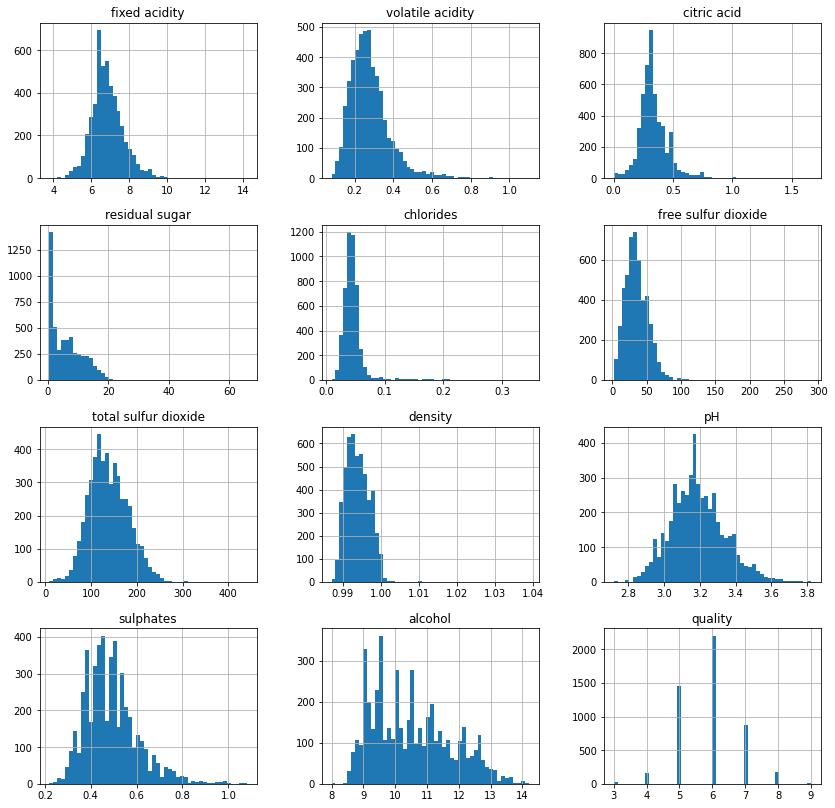

In [9]:
white_wine_df.hist(figsize=(14,14), bins=50, grid=True);

In [10]:
#Счет начинается со значения 3. Сместим значение целевого параметра на 3 единицы вниз.
# это уменьшит к-во классов исключив те для которых вообще нет примеров.

white_wine_df['quality']= white_wine_df['quality']-3

По графикам нетрудно определить, что в данных имеются выбросы. 

Выбросы могут негативно отразиться на качестве обучения модели.
Постараемся от них избавиться, установив вручную максимальное значение для параеметров, с для которых имеются значения с сильным отклоенеием от прочих парамеров.

In [11]:

white_wine_df.loc[(white_wine_df['free sulfur dioxide'] > 100),'free sulfur dioxide'] = 100

white_wine_df.loc[(white_wine_df['total sulfur dioxide'] > 300),'total sulfur dioxide'] = 300

# white_wine_df.loc[(white_wine_df['residual sugar'] > 25),'residual sugar'] = 25

# white_wine_df.loc[(white_wine_df['density'] > 1.01),'density'] = 1.01

# white_wine_df.loc[(white_wine_df['chlorides'] > 0.2),'chlorides'] = 0.2

In [12]:
x_data = white_wine_df.iloc[:,:-1]
y_data = white_wine_df.iloc[:,-1]

In [13]:
input_shape = x_data.shape[1]
print('К-во признаков:', input_shape)

К-во признаков: 11


In [14]:
# Получим список признаков. 
numerical = [col for col, value in x_data.iteritems()]
numerical

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [15]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, random_state=1,test_size=0.2,stratify=y_data)

In [16]:
preprocessor =  make_column_transformer(
                                        (StandardScaler(), numerical) # make_column_selector(dtype_include=np.number)),
                                       )

In [17]:
X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.fit_transform(X_test)

Попытка уровнять к-во объектов разных классов не привела к улучшению качества. Только ухудшила его. 

Оставим данный код закомментрированным.

In [18]:
# print('Original dataset shape %s' % Counter(y_train))

# sm = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=1)

In [19]:
# X_train, y_train = sm.fit_resample(X_train, y_train)

# print('Resampled dataset shape %s' % Counter(y_train))

In [20]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\r\nTEST')
    print()
    print(pd.crosstab(y_test_true, y_test_pred))

Задачу тардиционно постараемся решить двумя способами. Классическим и с помощью нейронных сетей.



### LGBMRegressor

In [21]:
model_lgbm = lgbm.LGBMRegressor(random_state=21,
                                max_depth=7,
                                n_estimators=300
                               )

In [22]:
model_lgbm.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=7,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
              random_state=21, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [23]:
y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

In [24]:
r2_score(y_train,y_train_pred)

0.8771959166545589

In [25]:
r2_score(y_test,y_test_pred)

0.5106483219826556

In [26]:
y_test_pred = list(map(round,y_test_pred))
y_train_pred = list(map(round,y_train_pred))

In [27]:
print(pd.Series(y_test_pred[:10]).values)
print(y_test.values[:10])

[2 3 2 3 3 2 2 3 3 3]
[2 3 4 4 3 2 3 3 3 3]


In [28]:
get_classification_report(y_train, pd.Series(y_train_pred), y_test, pd.Series(y_test_pred))

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.12      0.22        16
           1       0.85      0.60      0.70       130
           2       0.91      0.90      0.91      1166
           3       0.89      0.96      0.92      1758
           4       0.87      0.86      0.87       704
           5       0.96      0.54      0.69       140
           6       0.00      0.00      0.00         4

    accuracy                           0.89      3918
   macro avg       0.78      0.57      0.62      3918
weighted avg       0.89      0.89      0.89      3918

TEST

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.17      0.03      0.05        33
           2       0.68      0.67      0.67       291
           3       0.65      0.72      0.69       440
           4       0.54      0.59      0.56       176
           5       0.83      0.14      0.24        35
           

## NN

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense,InputLayer,BatchNormalization,Dropout
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.activations import relu, sigmoid, linear, tanh, elu,selu 
from tensorflow.keras.callbacks import EarlyStopping 

from tensorflow.keras.utils import to_categorical

In [30]:
model = Sequential()

model.add(InputLayer(input_shape))
model.add(Dense(512, activation= 'relu'))
model.add(BatchNormalization())

model.add(Dense(256, activation= 'relu'))
model.add(BatchNormalization())

# model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               6144      
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

In [31]:
optimazer = Adam(learning_rate=0.0001)

In [32]:
model.compile(loss='mean_squared_error', optimizer=optimazer, metrics=['mae'])

In [33]:
early_stop = EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)

In [34]:
history = model.fit(X_train,y_train,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop],
                    batch_size=10,
                    verbose=1
                   )

Epoch 1/100
392/392 [==============================] - 3s 4ms/step - loss: 8.5165 - mae: 2.6869 - val_loss: 5.7278 - val_mae: 2.2551
Epoch 2/100
392/392 [==============================] - 2s 4ms/step - loss: 6.0495 - mae: 2.2698 - val_loss: 5.0697 - val_mae: 2.0897
Epoch 3/100
392/392 [==============================] - 2s 4ms/step - loss: 4.0859 - mae: 1.8159 - val_loss: 3.2129 - val_mae: 1.6263
Epoch 4/100
392/392 [==============================] - 2s 4ms/step - loss: 2.5180 - mae: 1.3596 - val_loss: 1.7339 - val_mae: 1.1164
Epoch 5/100
392/392 [==============================] - 2s 4ms/step - loss: 1.4371 - mae: 0.9800 - val_loss: 1.0437 - val_mae: 0.8117
Epoch 6/100
392/392 [==============================] - 2s 4ms/step - loss: 0.9626 - mae: 0.7702 - val_loss: 0.6859 - val_mae: 0.6477
Epoch 7/100
392/392 [==============================] - 1s 4ms/step - loss: 0.7328 - mae: 0.6779 - val_loss: 0.6026 - val_mae: 0.6044
Epoch 8/100
392/392 [==============================] - 2s 4ms/step - 

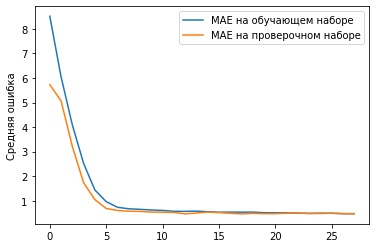

Loss: 0.462
MAE: 0.532


In [35]:
plt.plot(history.history['loss'][:], label='MAE на обучающем наборе')
plt.plot(history.history['val_loss'][:], label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

lstm_loss,lstm_mae = model.evaluate(X_test, y_test, verbose=0)

print(f'Loss: {lstm_loss:.3f}')
print(f'MAE: {lstm_mae:.3f}')

In [36]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [37]:
r2_score(y_train,y_train_pred)

0.47525123357542975

In [38]:
r2_score(y_test,y_test_pred)

0.4118041205731542

In [39]:
y_train_pred = y_train_pred.reshape(1, len(y_train_pred))
y_test_pred = y_test_pred.reshape(1, len(y_test_pred))

In [40]:
y_train_pred = np.array(np.round(y_train_pred), dtype='int')
y_test_pred = np.array(np.round(y_test_pred), dtype='int')

In [43]:
print(y_test_pred[0][:10])
print(y_test[:10].values)

[2 3 4 3 3 2 2 3 3 3]
[2 3 4 4 3 2 3 3 3 3]


In [42]:
get_classification_report(y_train, y_train_pred[0], y_test, y_test_pred[0])

TRAIN

              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         0
          -1       0.00      0.00      0.00         0
           0       0.13      0.12      0.13        16
           1       0.43      0.15      0.23       130
           2       0.67      0.58      0.62      1166
           3       0.61      0.71      0.65      1758
           4       0.50      0.55      0.53       704
           5       0.42      0.06      0.10       140
           6       0.00      0.00      0.00         4

    accuracy                           0.60      3918
   macro avg       0.31      0.24      0.25      3918
weighted avg       0.59      0.60      0.58      3918

TEST

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.33      0.15      0.21        33
           2       0.61      0.59      0.60       291
           3       0.58      0.62      0.60       440
           

### Вывод: 

При решении задачи классификации при определении качества вина. Нейронная сеть показала себя хуже чем LGBRegressor.